In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [2]:
from datasets import load_dataset

ds = load_dataset("worldcuisines/food-kb")

In [3]:
# View the structure of the dataset
#print(ds)

In [4]:
main_ds=ds["main"].to_pandas()
#print(main_ds.iloc[:5])

In [5]:
# Enable text wrapping by adjusting display options
pd.set_option("display.max_colwidth", None)  # Show full content of cells
#print(main_ds.iloc[0:5,15])

In [1]:
#print(main_ds.loc[0:5,"image6_url"])

In [6]:
print(main_ds["coarse_categories"].explode().unique())

['soup' 'stew' 'meat' 'rice' 'bread' 'dessert' 'pancake' 'dim sum' 'dough'
 'snack' 'fish' 'vegetable' 'seafood' 'fruit' 'chicken' 'beverages'
 'side dish' 'dumpling' 'lamb' 'sweets' 'fritter' 'noodle' 'rice cake'
 'cereal' 'curry' 'canned food' 'pastry' 'cake' 'pasta' 'salad'
 'finger food' 'vegetables' 'cutlet' 'potato' 'crepe' 'doughnut' 'pudding'
 'skewer' 'wrap' 'tofu' 'soybeans' 'stir fry' 'corn' 'egg' 'beans'
 'biscuit' 'cookies' 'roll' 'pizza' 'sandwich' 'confectionery' 'condiment'
 'dairy' 'grain' 'porridge' 'cheese' 'banana' 'casserole' 'spice' 'seed'
 'meatball' 'dip' 'stuffed food' 'omelette' 'seaweed' 'butter' 'stock'
 'hot pot' 'sweet paste' 'sugar' 'candy' 'jelly' 'sweetener' 'spread'
 'tortilla' 'platter' 'lentil' 'pie' 'gravy' 'nuts' 'peas' 'sausage'
 'mutton' 'caviar' 'sauce' 'flatbread' 'carrot' 'paste']


In [7]:
food=main_ds


In [8]:
# Replace 'features' and 'target_column' with the actual column names
from sklearn.model_selection import train_test_split

features = food.drop(columns=["coarse_categories"])  # Drop target column for features
target = main_ds["coarse_categories"]  # Select target column

# Split the dataset into 80% training and 20% testing
food_train, food_test, category_train, category_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Training Features Shape:", food_train.shape)
print("Test Features Shape:", food_test.shape)
print("Training Labels Shape:", category_train.shape)
print("Test Labels Shape:", category_test.shape)

Training Features Shape: (1931, 37)
Test Features Shape: (483, 37)
Training Labels Shape: (1931,)
Test Labels Shape: (483,)


In [36]:
#print(main_ds.loc[0:5,["image1_url","image2_url","image3_url","image4_url"]])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import re

# Function to fetch and preprocess images
def fetch_and_preprocess_image(url, target_size=(255, 255)):
    try:
        headers = {
                  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                  }
        response = requests.get(url, headers=headers, stream=True)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    except Exception as e:
        print(f"Error fetching image from {url}: {e}")
        return None
        
food=food[["image1_url","coarse_categories"]]
# Fetch images and labels
images = []
labels = []
for _, row in food.iterrows():
    if row["image1_url"] is not None:
        row["image1_url"]=re.sub(r"\?.*$", "",row["image1_url"])
        image = fetch_and_preprocess_image(row["image1_url"])
        if image is not None:
            if labels is not None:
                images.append(image)
                labels.append(row["coarse_categories"])


Error fetching image from https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Laugenbroetchen_fcm.jpg/1440px-Laugenbroetchen_fcm.jpg: cannot identify image file <_io.BytesIO object at 0x000001B59C682660>
Error fetching image from https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Pavlova%2C_dessert.jpeg/1920px-Pavlova%2C_dessert.jpeg: cannot identify image file <_io.BytesIO object at 0x000001B677324450>
Error fetching image from https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Wiener_Wuerstchen_fcm.jpg/1280px-Wiener_Wuerstchen_fcm.jpg: cannot identify image file <_io.BytesIO object at 0x000001B59A733600>


In [165]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# maintain only one category in each nested list

labels = [lst[:1] for lst in labels]

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


# Ensure labels are 1D
y_train = y_train.ravel()
y_val = y_val.ravel()

# Combine all unique labels
all_labels = np.concatenate([y_train, y_val])

#len(all_labels)# Fit the LabelEncoder on the combined labels
label_encoder = LabelEncoder()


# Transform the labels
label_encoder.fit(all_labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
#label_encoder.fit(all_labels)

# One-hot encode labels
num_classes = len(np.unique(labels))  # Number of unique classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# CNN Sequential model 
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),  # Additional layer for deeper feature extraction
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # For multi classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

C:\Users\harik\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.0916 - loss: 5.5451 - val_accuracy: 0.1362 - val_loss: 3.4471
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1199 - loss: 3.4945 - val_accuracy: 0.1473 - val_loss: 3.3056
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1304 - loss: 3.3392 - val_accuracy: 0.1071 - val_loss: 3.2694
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1187 - loss: 3.3179 - val_accuracy: 0.1071 - val_loss: 3.2493
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1238 - loss: 3.2548 - val_accuracy: 0.1362 - val_loss: 3.2400
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1314 - loss: 3.2506 - val_accuracy: 0.1071 - val_loss: 3.2489
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1192 - loss: 3.2495 - val_accuracy: 0.1362 - val_loss: 3.2407
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1350 - loss: 3.2577 - val_accuracy: 0.1362 - val_loss:

In [138]:
#len(all_labels)
#labels = [label[0] if isinstance(label, list) else label for label in labels]
#labels = [label for label in labels if label is not None]
#label_encoder = LabelEncoder()
#labels = label_encoder.fit_transform(labels)
y_train = y_train.ravel()
print(y_train)

[0. 0. 0. ... 0. 0. 0.]


In [132]:
#print(labels[:10])
#print([type(label) for label in labels])
#print("Class Mapping:", dict(enumerate(label_encoder.classes_)))

https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Soto_Betawi_Glodok.JPG/1024px-Soto_Betawi_Glodok.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Class: ['soup']


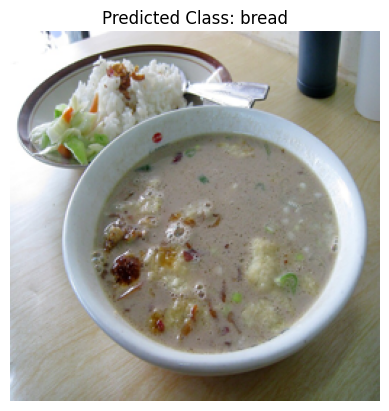

In [200]:
#len(labels)
#print(labels)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Prediction on unseen images
new_image_url=main_ds.iloc[1,18]
new_image_url=re.sub(r"\?.*$", "",new_image_url)
new_image=fetch_and_preprocess_image(new_image_url, target_size=(255, 255))
# Add a batch dimension to the preprocessed image
new_image1 = np.expand_dims(new_image, axis=0)  # Shape becomes (1, 128, 128, 3)
print(new_image_url)

new_label_prediction=model.predict(new_image1)
predicted_label_index = np.argmax(new_label_prediction, axis=1)[0]
class_label = label_encoder.inverse_transform([predicted_label_index])[0]
plt.imshow(new_image)
#new_image_url=image.open(new_image_url.raw)
#plt.imshow(new_image_url)

print(f'Actual Class: {main_ds.loc[1,"coarse_categories"]}')
plt.title(f"Predicted Class: {class_label}")
plt.axis('off')
plt.show()
